## data load

In [16]:
from bs4 import BeautifulSoup

In [17]:
from glob import glob

In [18]:
path_a = glob("data/a/*.html")
path_n = glob("data/n/*.html")

In [47]:
import dataclasses

In [49]:
@dataclasses.dataclass
class Aozora:
    label: str = ""
    soup: BeautifulSoup = None 
    author: str = ""
    title: str = ""
    text: str = ""

In [51]:
data = []

for p in path_a:
    with open(p, encoding="Shift_JIS") as f:
        html = f.read()
        soup = BeautifulSoup(html)
        data += [Aozora(label="a", soup=soup)]

for p in path_n:
    with open(p, encoding="Shift_JIS") as f:
        html = f.read()
        soup = BeautifulSoup(html)
        data += [Aozora(label="n", soup=soup)]

In [22]:
from sudachipy import tokenizer
from sudachipy import dictionary

tokenizer_obj = dictionary.Dictionary().create()
mode = tokenizer.Tokenizer.SplitMode.A

In [57]:
from tqdm import tqdm

In [58]:
for i in tqdm(range(len(data))):
    soup = data[i].soup
    author, title = soup.find_all("title")[0].text.split()[:2]
    text = soup.find_all("div", class_="main_text")[0].text
    
    data[i].author = author
    data[i].title = title
    data[i].text = tokenizer_obj.tokenize(text, mode)
    

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [11:18<00:00, 67.86s/it]


In [82]:
for i in range(len(data)):
    print(data[i].title, len([t for t in data[i].text]))
    data[i].josi = [t.surface() for t in data[i].text if t.part_of_speech()[0]=="助詞"]

鼻 4603
蜘蛛の糸 2108
トロッコ 3493
河童 27171
羅生門 4471
坊っちゃん 69930
三四郎 116896
こころ 126881
彼岸過迄 155900
吾輩は猫である 247538


In [139]:
# 助詞bigram
from sklearn.feature_extraction.text import CountVectorizer
vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(2, 2))
X2 = vectorizer2.fit_transform([" ".join(ao.josi) for ao in data])
#print(vectorizer2.get_feature_names())

# 正規化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X2.todense())

## 階層型クラスタリング

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

# matplotlibが認識してるフォントPATH一覧てきなもの
fonts = fm.findSystemFonts()

# 日本語フォントはだいたいファイル名に"CJK"を含む
jp_fonts = [f for f in fonts if "CJK" in f]
# print(jp_fonts)

# iは何でもよい
i = 0
# PATH
print(jp_fonts[i])
# フォント名
# ここで取得した名前をrcParamsにセットする必要がある
font_family = fm.FontProperties(fname=jp_fonts[i]).get_name()
print(font_family)

# セット
plt.rcParams['font.family'] = font_family
print(plt.rcParams['font.family'])

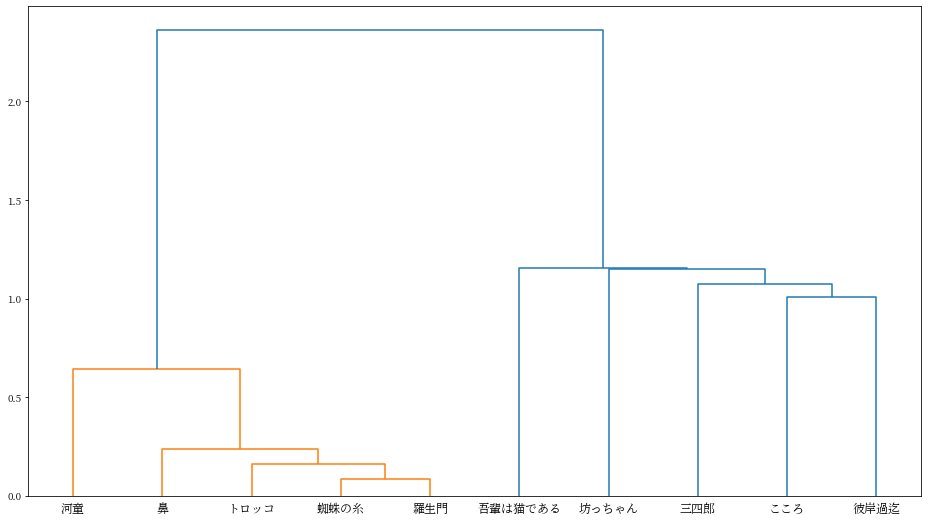

In [144]:
from scipy.cluster import hierarchy
Y = hierarchy.distance.pdist(X, metric='cosine')
Z = hierarchy.linkage(Y, method="ward")

fig, ax = plt.subplots(figsize=(16,9))
ax = hierarchy.dendrogram(Z=Z,
                orientation='top',
                color_threshold=1,
                labels=[d.title for d in data])

In [146]:
fig.savefig("aozora.png")